In [ ]:
# default_exp nbeats.interpret

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

# Interpret

> Interpret the results of a model

In [ ]:
# export
from fastseq.all import *
from fastseq.data.external import *
from fastai.basics import *
from fastseq.nbeats.learner import *
from fastseq.nbeats.callbacks import *


(1, 60)
Train:400; Valid: 200; Test 100


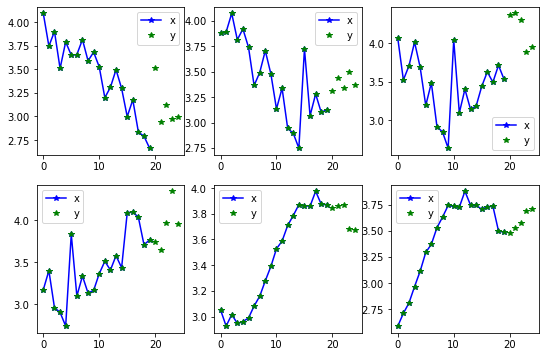

In [ ]:
items = dummy_data_generator(50, 10, nrows=100)
dbunch = TSDataLoaders.from_items(items, horizon = 5, lookback = 20, step=5, num_workers=0)
dbunch.show_batch(max_n=6)

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=1.9054607491852948e-06)

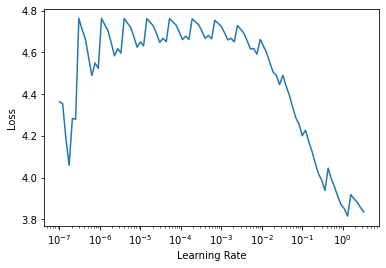

In [ ]:
learn = nbeats_learner(dbunch, layers=[100])
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,theta,b_loss,f_loss,f_smape,time
0,4.182195,3.121185,0.856546,1.468537,0.306380,nan,nan,0.302896,00:00
1,3.637532,1.990547,0.704278,1.087947,0.877818,nan,nan,0.198957,00:00
2,3.340853,1.904122,0.720246,1.099201,1.018821,nan,nan,0.182377,00:00
3,3.055051,1.771977,0.694941,1.081834,0.964516,nan,nan,0.171598,00:00
4,2.888288,1.802640,0.695153,1.046482,0.944445,nan,nan,0.170727,00:00


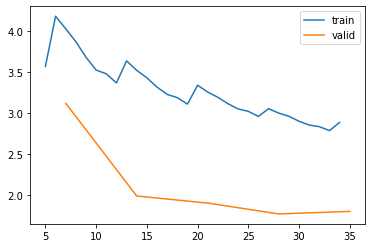

In [ ]:
learn.fit_flat_cos(5, 2e-1, wd=0.1, cbs=cb)
learn.recorder.plot_loss()

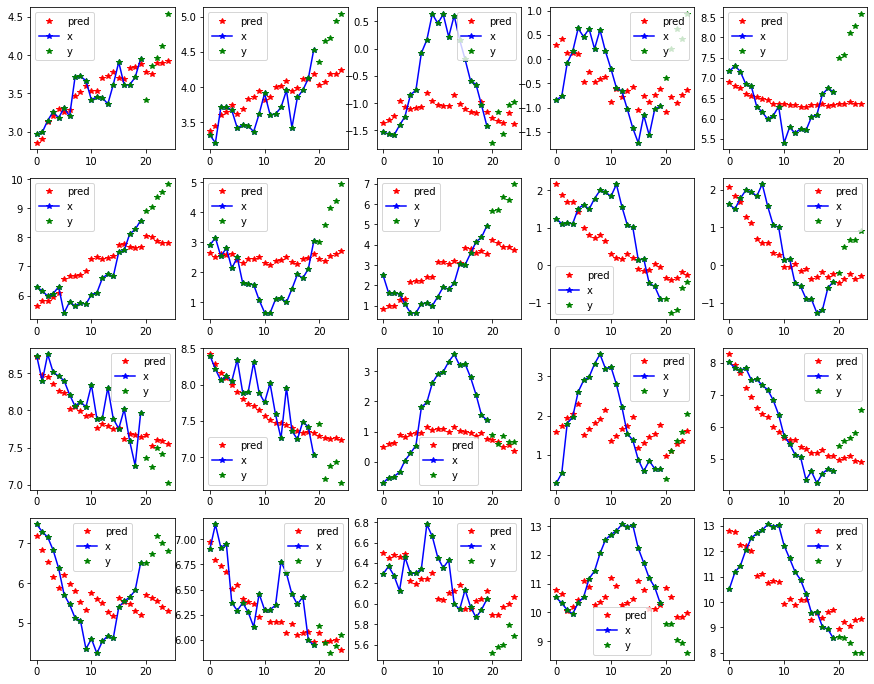

In [ ]:
learn.show_results(max_n=20)

In [ ]:
learn.metrics = []

In [ ]:
# export
from fastseq.nbeats.callbacks import _get_key_from_nested_dct

In [ ]:
dct = {'foo':{'bar':1},'bar':2,'foo2':{'foo3':3},'ignore':{'bar':1000}}
r = _get_key_from_nested_dct(dct,'bar',['ignore'])
test_eq(r,{'foobar': 1, 'bar': 2})
r

{'foobar': 1, 'bar': 2}

In [ ]:
# hide
idx = torch.arange(9)
cb = Components()
try:
    learn.add_cb(cb)
    _ = learn.get_preds(dl=learn.dls[1], with_input=True, with_loss=True, with_decoded=True, reorder=False)
finally:
    learn.remove_cb(cb)
_l_dct = cb.stored


# {block + '_f':l_dct[block]['f'][idx,:].shape for block in l_dct if 'total' not in block} 


In [ ]:
# export
class NBeatsInterpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, inputs, preds, targs, decoded, losses, full_every_block = None):
        store_attr( "dl,inputs,preds,targs,decoded,losses,full_every_block")

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretatio object from a learner"
        if dl is None: dl = learn.dls[ds_idx]
        cb = Components()
        learn.add_cb(cb)
        res = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None, reorder=False)
        learn.remove_cb(cb)       
        return cls(dl, *res, full_every_block=cb.stored)

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)
    

In [ ]:
from fastai.interpret import *

In [ ]:
interp = NBeatsInterpretation.from_learner(learn)

In [ ]:
# export 
def add_stack(b):
    res = {}
    print('add stack before',b.keys())
    for stack in set([o[:-4] for o in b.keys()]):
        for direction in ['f','b']:
            for key in b.keys():
                if stack in key and direction == key[-1] :
                    if stack+'_'+direction in res:
                        res[stack+'_'+direction] += b[key]
                    else:
                        res[stack+'_'+direction] = b[key]
    print('add stack after',res.keys())
    return res

def add_stack_full(b):
    res = {}
    for stack in set([o[:-7] for o in b.keys()]):
        for key in b.keys():
            direction = 'full'
            if stack in key and direction in key:
                if stack+'_'+direction in res:
                    res[stack+'_'+direction] += b[key]
                else:
                    res[stack+'_'+direction] = b[key]
    return res
               

In [ ]:
dct = {'bias0_0_f':torch.ones(1,1), 'bias0_1_f': torch.ones(1,1), 'bias0_2_f': torch.ones(1,1),'bias0_1_b': torch.ones(1,1)*10,
       'trend1_0_f': torch.ones(1,1)*100, 'trend1_1_f':torch.ones(1,1)*100}
res = add_stack(dct)
test_eq(res,{'trend1_f': tensor([[200.]]), 'bias0_f': tensor([[3.]]), 'bias0_b': tensor([[10.]])})

dct = {'bias0_0_full':torch.ones(1,1), 'bias0_1_full': torch.ones(1,1), 'bias0_2_full': torch.ones(1,1),
        'trend1_1_full':torch.ones(1,1)*100,'trend1_2_full':torch.ones(1,1)*100}
res = add_stack_full(dct)
test_eq(res,{'trend1_full':torch.ones(1,1)*200,'bias0_full': tensor([[3.]])})

add stack before dict_keys(['bias0_0_f', 'bias0_1_f', 'bias0_2_f', 'bias0_1_b', 'trend1_0_f', 'trend1_1_f'])
add stack after dict_keys(['bias0_f', 'bias0_b', 'trend1_f'])


In [ ]:
# export
def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)   
#         total_b = self.dct['b'][idx.long(), :]        
#         keys_wo_total_b = [o for o in list(self.dct.keys()) if 'total_b' not in o]
        if not isinstance(self.inputs, tuple): 
            self.inputs = (self.inputs,)
            
        if isinstance(self.inputs[0], Tensor): 
            inps = tuple(o[idx] for o in self.inputs)
            self.dl.after_batch(inps)
        else: 
            xb = [tuple(o[i] for o in self.inputs) for i in idx]
            inps = self.dl.create_batch(self.dl.before_batch(xb))
        assert self.dl.after_batch[0].m.shape[0] == k
            
        b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))   
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        full_every_block = [{k:self.dl.after_batch.decode((o[i,None,:]))[0][0][0] for k,o in self.full_every_block .items()} for i in idx]
        b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
#         return self.preds[idx], full_every_block
        if its is not None:
            ts_plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses,blocks= full_every_block, **kwargs)
#         #TODO: figure out if this is needed
#         #its None means that a batch knos how to show itself as a whole, so we pass x, x1
#         else: 
#         show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)
NBeatsInterpretation.plot_top_losses = plot_top_losses

In [ ]:
#export
def ts_plot_top_losses(x:TSTensorSeq, y:TSTensorSeqy, *args, blocks=[], total_b=None, combine_stack=False,
                    rows=None, cols=None, figsize=None, **kwargs):
    
    figsize = (2*3, x.shape[0]*3+0) if figsize is None else figsize
    _, axs = plt.subplots(x.shape[0], 2, figsize=figsize, sharey='row')
    axs = axs.flatten()
    normal = np.arange(0,x.shape[0]*2,2)
    
    for i, (_x, _y, block, pred, t) in enumerate(zip(x, y, blocks, args[2], args[3])):
        if combine_stack:
            block = add_stack_full(block)
        ax = axs[i*2]
        ctx = show_graph(_x, ax=ax, title=str(f"loss:{np.round(t.data.item(),2)}"), label='x')
        TSTensorSeqy(_y, m = '*g', label = 'y').show(ctx=ctx)
        TSTensorSeqy(pred, m = '-*r', label = 'pred').show(ctx=ctx)
        ax = axs[i*2 + 1]
        total = torch.zeros_like(block[list(block.keys())[0]])
        for k, c in zip(block.keys(), ['y','k','g','r','b','k','b','b']):
#             if 'season' in k:
            ax = TSTensorSeqy(block[k], m = '-*'+c, label = k.replace('_full','')).show(ctx=ax)
            total += block[k]
            ax.legend(bbox_to_anchor=(1.2, 1.05), ncol=3, fancybox=True)
            
        
#         ax = TSTensorSeqy(-total, m = '-*y', label= 'tot').show(ctx=axs[i*2])
        ax.legend()            
    

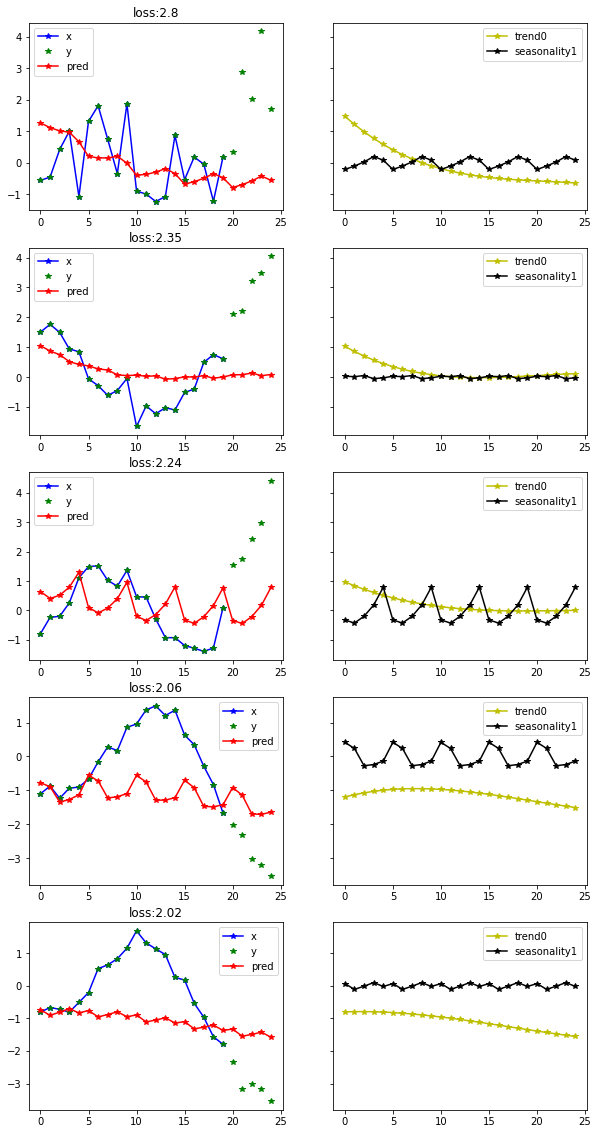

In [ ]:
interp.plot_top_losses(5, combine_stack= True, figsize=(10,20))

TODO: make the scale work 
TODO2: something seems of besides the scale the last part seems not to be shown

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
